# Alpaca Identification : Issue #93

### Model Used : VGG - 16 CNN

### Model Summary : 

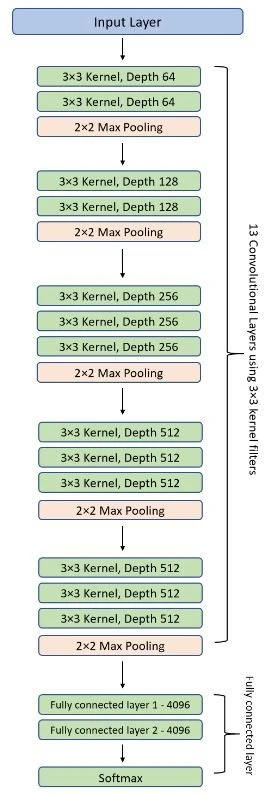

In [9]:
#importing libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Rescaling,Dense,Flatten,MaxPool2D,Conv2D,Activation,Dropout,RandomRotation,RandomTranslation,RandomContrast,RandomBrightness

from keras import backend as K
import keras

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import PIL
import PIL.Image
import pathlib

In [11]:
#Function that returns the VGG16 Model 

def model_VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='lastConvpointer'))
    model.add(Flatten(name='flatten'))
    model.add(Rescaling(1./255))
    model.add(Dense(4096, activation='relu', name='fc1'))
    model.add(Dense(4096, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output')) #since the classification is binary, I am using sigmoid here.
    return model

In [12]:
#Making the training path ( for both alpacas and non-alpacas )

trainingpath = "C:\\Users\\evanj\\Desktop\\Alpaca Detector\\Dataset"
class_names=os.listdir(trainingpath)
data_dir = trainingpath
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

#Changing the image dimensions according to out VGG_NET
img_height = 224
img_width = 224

total_ds = keras.utils.image_dataset_from_directory(
  data_dir,image_size=(img_height, img_width),batch_size=1)

class_names = total_ds.class_names
print(class_names)

Found 327 files belonging to 2 classes.
['Alpaca', 'notAlpaca']


In [13]:
# Using augmentation for more data

"""""
datagen_rotra = keras.Sequential([RandomRotation(0.2),RandomTranslation(0.2,0.2)])
datagen_contrness = keras.Sequential([RandomContrast(0.2),RandomBrightness(0.2)])

rotra_ds, contrness_ds = keras.utils.split_dataset(total_ds,left_size = 0.2,right_size=0.2)

rotra_ds = rotra_ds.map(lambda x, y:(datagen_rotra(x),y))
contrness_ds = contrness_ds.map(lambda x, y:(datagen_contrness(x),y))

#total_ds = total_ds = contrness_ds.map(lambda x, y:(x,y))
augmented_ds = contrness_ds.concatenate(rotra_ds)
total_ds = total_ds.concatenate(augmented_ds) 
"""""

'""\ndatagen_rotra = keras.Sequential([RandomRotation(0.2),RandomTranslation(0.2,0.2)])\ndatagen_contrness = keras.Sequential([RandomContrast(0.2),RandomBrightness(0.2)])\n\nrotra_ds, contrness_ds = keras.utils.split_dataset(total_ds,left_size = 0.2,right_size=0.2)\n\nrotra_ds = rotra_ds.map(lambda x, y:(datagen_rotra(x),y))\ncontrness_ds = contrness_ds.map(lambda x, y:(datagen_contrness(x),y))\n\n#total_ds = total_ds = contrness_ds.map(lambda x, y:(x,y))\naugmented_ds = contrness_ds.concatenate(rotra_ds)\ntotal_ds = total_ds.concatenate(augmented_ds) \n'

In [14]:
train_ds ,val_ds= keras.utils.split_dataset(total_ds,left_size = 0.8, right_size = 0.2, seed=7)

In [16]:
#To show the summary of our model
#name of the model used is booModel (just for fun)

booModel = model_VGG16()

booModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [17]:
#to select the layers which we are going to add weights from original VGG_NET (found from kaggle, is cited below)

Layers_not2bTND = Model(inputs=booModel.input, outputs=booModel.get_layer('lastConvpointer').output)
Layers_not2bTND.load_weights("C:\\Users\\evanj\\Desktop\\Alpaca Detector\\extras\\vgg16_weights.h5")

#to prevent the convlayers to train

for layer in Layers_not2bTND.layers:
    layer.trainable = False
    
booModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [18]:
#Using ADAM as optimiser here.
#lr_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 10000, decay_rate = 0.99)
opt = Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
#Compiling the Model
booModel.compile(loss="binary_crossentropy",optimizer = opt, metrics = ["accuracy"])

In [19]:
#defining Early Stopping to prevent overfitting
es=EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
#To save the best Model
mc = ModelCheckpoint('C:\\Users\\evanj\\Desktop\\Alpaca Detector\\extras\\best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [20]:
#Creating the model.
H = booModel.fit(train_ds,batch_size=1,validation_data=val_ds,epochs=100,verbose=1,callbacks=[mc,es])

Epoch 1/100
262/262 [==============================] - 155s 590ms/step - loss: 2.8711 - accuracy: 0.5840 - val_loss: 0.4406 - val_accuracy: 0.8615
Epoch 2/100
262/262 [==============================] - 148s 563ms/step - loss: 12.4721 - accuracy: 0.8244 - val_loss: 3.7263 - val_accuracy: 0.8923
Epoch 3/100
262/262 [==============================] - 145s 553ms/step - loss: 14.9611 - accuracy: 0.8969 - val_loss: 3.7420 - val_accuracy: 0.8923
Epoch 4/100
262/262 [==============================] - 143s 548ms/step - loss: 4.9672 - accuracy: 0.9351 - val_loss: 4.4959 - val_accuracy: 0.8923
Epoch 5/100
262/262 [==============================] - 146s 556ms/step - loss: 3.5075 - accuracy: 0.9771 - val_loss: 40.5079 - val_accuracy: 0.6615
Epoch 6/100
262/262 [==============================] - 143s 547ms/step - loss: 18.3011 - accuracy: 0.9046 - val_loss: 9.2093 - val_accuracy: 0.8923
Epoch 7/100
262/262 [==============================] - 144s 552ms/step - loss: 40.2262 - accuracy: 0.9618 - val_lo

In [22]:
import seaborn as sb

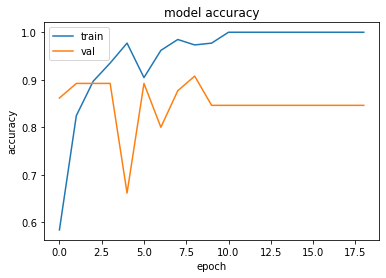

In [23]:
#Plotting accuracy
plt.plot(booModel.history.history['accuracy'])
plt.plot(booModel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

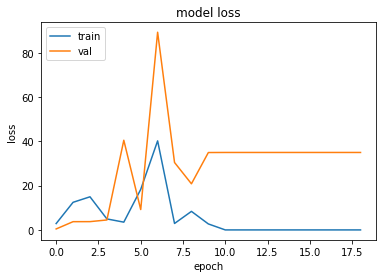

In [24]:
#plotting loss
plt.plot(booModel.history.history['loss'])
plt.plot(booModel.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 744ms/step
The images is of : notAlpaca
1/1 [==============================] - 0s 100ms/step
The images is of : Alpaca
1/1 [==============================] - 0s 105ms/step
The images is of : Alpaca
1/1 [==============================] - 0s 104ms/step
The images is of : Alpaca
1/1 [==============================] - 0s 105ms/step
The images is of : Alpaca
1/1 [==============================] - 0s 105ms/step
The images is of : notAlpaca
1/1 [==============================] - 0s 109ms/step
The images is of : notAlpaca
1/1 [==============================] - 0s 110ms/step
The images is of : notAlpaca
1/1 [==============================] - 0s 114ms/step
The images is of : notAlpaca
1/1 [==============================] - 0s 101ms/step
The images is of : notAlpaca


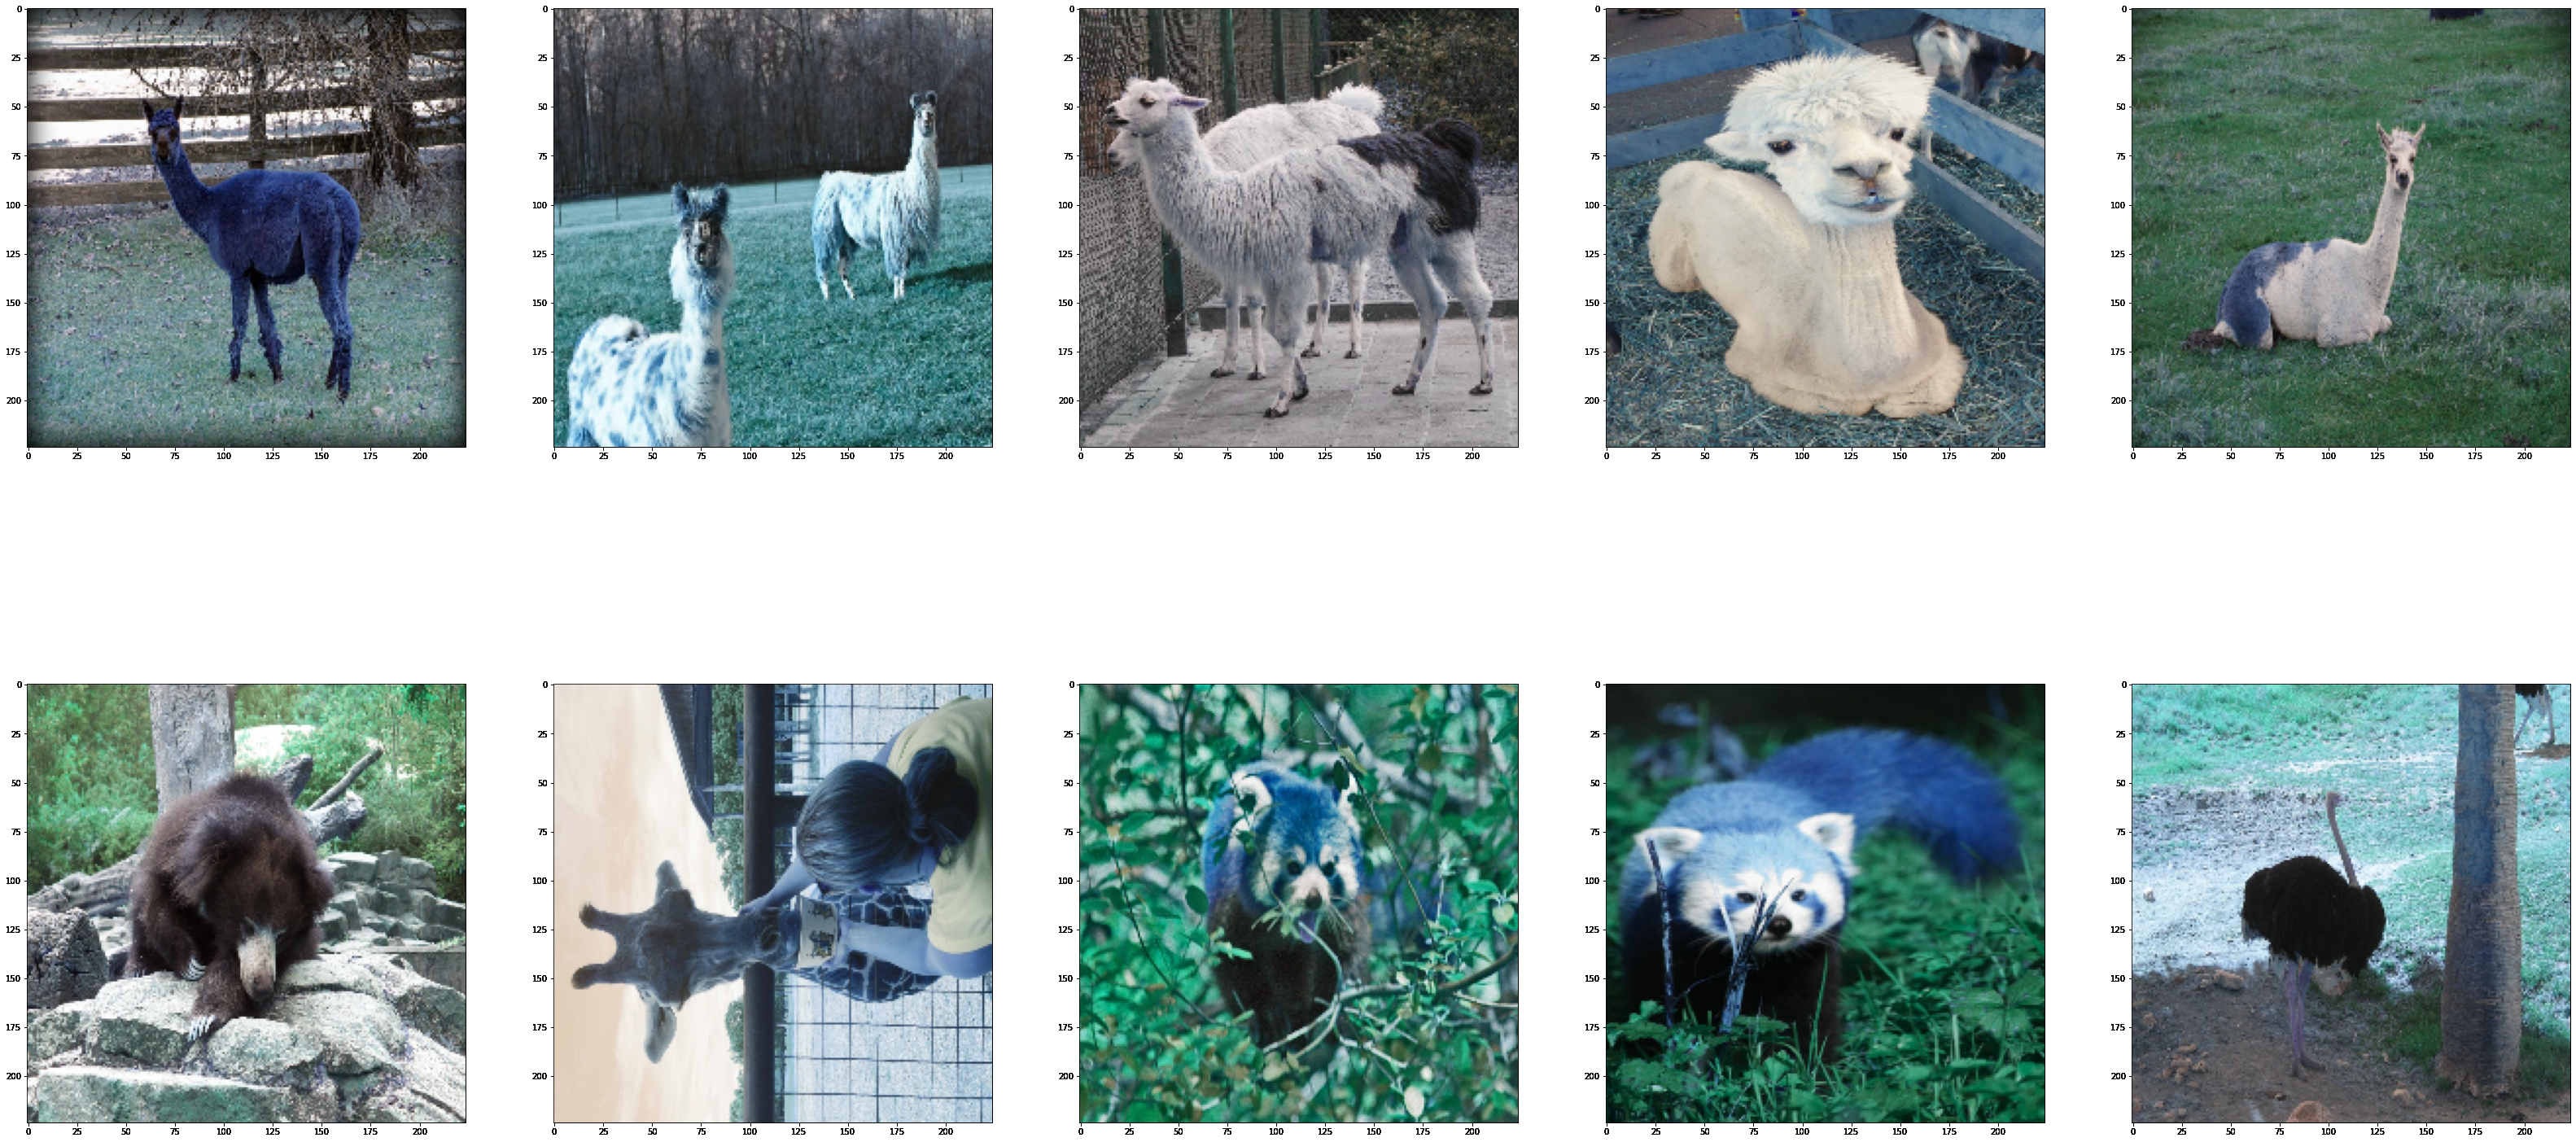

In [25]:
#Now we view some random Predictions

PredModel = load_model("C:\\Users\\evanj\\Desktop\\Alpaca Detector\\extras\\best_model.h5")
PredModel.compile(loss="binary_crossentropy",optimizer = opt, metrics = ["accuracy"])

AlpacaPaths = [r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\0e6044cdcd9318f3.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\3e7c07126e64eecd.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\5ac0d56bc8faf013.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\8da88ce905084374.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\24b9fb051f8cdfa2.jpg"]
notAlpacaPaths =[r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\0df78ee76bafd3a9.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\1a6edbe4ab6efe39.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\3ef9a8ea639d0d2f.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\7d8bf3ff2ae7948e.jpg",r"C:\Users\evanj\Desktop\Alpaca Detector\PredictionSet\8311dc486dbf1619.jpg"]

fig=plt.figure(figsize=(56,56))
img = []
for i in range(5):
    img.insert(i,cv2.imread(AlpacaPaths[i]))
    img[i] = cv2.resize(img[i],(224,224))

    rows,cols = 1,5
    for j in range(0,cols*rows):
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img[i])
    
    img[i] = np.reshape(img[i],[1,224,224,3])

        
    classes = PredModel.predict(img[i])
    
    print("The images is of : " + class_names[int(np.round(np.squeeze(classes)))])
    
for i in range(5):
    img.insert(5+i,cv2.imread(notAlpacaPaths[i]))
    img[5+i] = cv2.resize(img[5+i],(224,224))

    rows,cols = 2,5
    for j in range(0,cols*rows):
        fig.add_subplot(rows,cols,i+6)
        plt.imshow(img[5+i])
    
    img[5+i] = np.reshape(img[5+i],[1,224,224,3])

        
    classes = PredModel.predict(img[5+i])

    print("The images is of : " + class_names[int(np.round(np.squeeze(classes)))])

plt.show()